# Prepare Enviromants

In [1]:
%pip install segmentation-models &> /dev/null
%load_ext tensorboard
!wget https://raw.githubusercontent.com/N-Jaro/segmentation_model_tutorial/main/unet_util.py
!cp '/content/drive/MyDrive/Meta_learning_research/Notebooks/data_util.py' .

# https://stackoverflow.com/questions/75433717/module-keras-utils-generic-utils-has-no-attribute-get-custom-objects-when-im
# open the file keras.py, change all the 'init_keras_custom_objects' to 'init_tfkeras_custom_objects'.
# the location of the keras.py is in the error message. In your case, it should be in /usr/local/lib/python3.8/dist-packages/efficientnet/
!wget https://raw.githubusercontent.com/N-Jaro/segmentation_model_tutorial/main/keras.py
!cp './keras.py' '/usr/local/lib/python3.10/dist-packages/efficientnet/keras.py'
!rm './keras.py'


# Other dependencies
import random
import sys
import time
import shutil
import numpy as np
import tensorflow as tf
from keras import backend as K
import segmentation_models as sm
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from unet_util import dice_coef_loss, dice_coef, jacard_coef, dice_coef_loss, Residual_CNN_block, multiplication, attention_up_and_concatenate, multiplication2, attention_up_and_concatenate2, UNET_224, evaluate_prediction_result
from data_util import *
sm.set_framework('tf.keras')
sm.framework()

# Reproduction
# np.random.seed(333)

print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

--2024-04-02 19:24:30--  https://raw.githubusercontent.com/N-Jaro/segmentation_model_tutorial/main/unet_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12771 (12K) [text/plain]
Saving to: ‘unet_util.py’

unet_util.py        100%[===================>]  12.47K  --.-KB/s    in 0s      

2024-04-02 19:24:30 (43.9 MB/s) - ‘unet_util.py’ saved [12771/12771]

--2024-04-02 19:24:31--  https://raw.githubusercontent.com/N-Jaro/segmentation_model_tutorial/main/keras.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 711 [text/plain]


# Define neccesary paths and models name

In [2]:
%cd '/content/drive/MyDrive/Meta_learning_research/Notebooks/'
import os
input_data = './samples/'
model_path = './models/'
prediction_path = './predicts/'
log_path = './logs/'

# Create the folder if it does not exist
os.makedirs(input_data, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(prediction_path, exist_ok=True)

# Avaiable backbones for Unet architechture
# 'vgg16' 'vgg19' 'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152' 'inceptionv3'
# 'inceptionresnetv2' 'densenet121' 'densenet169' 'densenet201' 'seresnet18' 'seresnet34'
# 'seresnet50' 'seresnet101' 'seresnet152', and 'attentionUnet'
backend = 'unet' # ResNet50 is the best model in the TL study

# Added first Convo 8 to 3 channels layers to the random init model
name = 'maml-model-' + backend + '-' + str(np.random.randint(1000000))

logdir = log_path + name
if(os.path.isdir(logdir)):
  shutil.rmtree(logdir)
os.makedirs(logdir, exist_ok=True)

print('model location: '+ model_path+name+'.h5')

/content/drive/MyDrive/Meta_learning_research/Notebooks
model location: ./models/maml-model-unet-430012.h5


## Initialize the model and parameters

In [3]:
# # Create U-net model with the chosen backbone
# # The U-net will be initialized with ImageNet weights and the ImageNet weights will be frozen
# # in the first pass training

# if (backend=="attentionUnet"):
#   # Attention U-net model
#   learning_rate = 0.0000359
#   unet_model = UNET_224()
#   unet_model.compile(optimizer = Adam(learning_rate=learning_rate),
#                 loss = dice_coef_loss,
#                 metrics = [dice_coef,'accuracy'])
# else:
#   # Unet with ImageNet backends
#   unet_model = sm.Unet(backend, classes = 1, encoder_weights='imagenet', encoder_freeze=True)

#   # Compile the model with 'Adam' optimizer (0.001 is the default learning rate) and define the loss and metrics
#   unet_model.compile(optimizer = Adam(),
#                 loss = dice_coef_loss,
#                 metrics=[dice_coef,'accuracy'])

# # Train the unet model
# # define hyperparameters and callback modules
# patience = 10
# maxepoch = 500
# callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience, min_lr=1e-9, verbose=1, mode='min'),
#             EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
#             ModelCheckpoint(model_path+name+'.h5', monitor='val_loss', save_best_only=True, verbose=0),
#             TensorBoard(log_dir=logdir)]

# MAML inner loop optimizer
optimizer = SGD()

# MAML outer loop optimizer
outer_optimizer = Adam()

# save the training history
train_history_all = []


In [4]:
# 2. Model Definition
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Expansive path
    u2 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u3 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet(input_shape=(224, 224, 8))

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 8)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      4672      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168

# Prepare Data Episodes

In [5]:
%cd '/content/drive/MyDrive/Meta_learning_research/Notebooks/'
data_dir = './samples/'  # Replace with the path to your directory containing numpy files
locations_meta_training = ['Alexander', 'Rowancreek']
locations_meta_testing = ['Covington']
num_samples_per_location = 10  # Configure the number of samples per location
num_episodes = 10  # Number of episodes

data_loader = MetaDataLoader(data_dir, num_samples_per_location)

# Create multi episodes for meta-training
mate_train_episodes = data_loader.create_multi_episodes(num_episodes, locations_meta_training)
mate_test_episodes = data_loader.create_multi_episodes(num_episodes, locations_meta_testing)

/content/drive/MyDrive/Meta_learning_research/Notebooks


# Define MAML Process

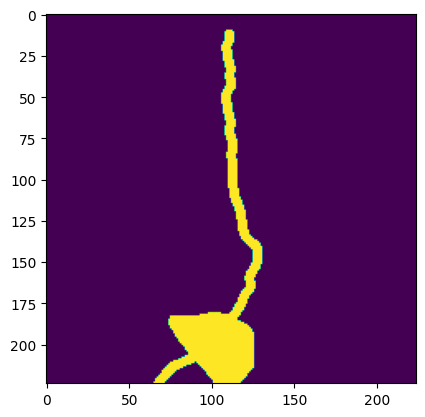

In [6]:
import matplotlib.pyplot as plt
plt.imshow(mate_test_episodes[0]['support_set_labels'][0])

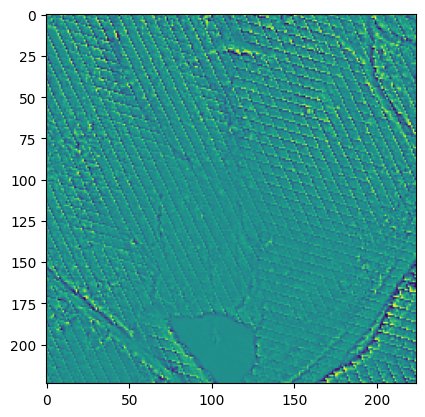

In [7]:
plt.imshow(mate_test_episodes[0]['support_set_data'][:,:,:,7][0])

In [8]:
def copy_model_fn(model):
    copied_model = build_unet(input_shape=(224, 224, 8))
    copied_model.set_weights(model.get_weights())
    return copied_model

In [9]:
def f1_loss(y_true, y_pred):
    # Define epsilon to prevent zero division
    epsilon = 1e-7

    # Calculate Precision and Recall
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    # Calculate F1
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    # Return negative F1 because we want to maximize it
    return 1 - f1

In [10]:
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (0.5 * focal_loss)
iou_score = tf.keras.metrics.MeanIoU(num_classes=2)

class MAML:
    def __init__(self, model, optimizer, inner_step_size, num_inner_steps):
        self.model = model
        self.optimizer = optimizer
        self.inner_step_size = inner_step_size
        self.num_inner_steps = num_inner_steps

        # Initialize a summary writer for TensorBoard logging
        self.summary_writer = tf.summary.create_file_writer('logs/')

    def inner_update(self, support_data, support_labels, original_weights):

        with tf.GradientTape() as task_tape:
            copied_model = copy_model_fn(self.model)
            task_preds = copied_model(support_data)
            # task_loss = f1_loss(support_labels, task_preds)
            task_loss = tf.keras.losses.binary_crossentropy(support_labels, task_preds)
            task_gradients = task_tape.gradient(task_loss,copied_model.trainable_variables)
            # task_gradients = [tf.clip_by_norm(g, 1.0) for g in task_gradients]
        fast_weights = [w - self.inner_step_size * g for w, g in zip(original_weights, task_gradients)]

        # print(f"Task Loss: {(task_loss):.4f}")

        return fast_weights, task_loss.numpy()

    def outer_update(self, episode):
        original_weights = self.model.get_weights()

        # Inner update
        fast_weights, task_loss = self.inner_update(episode['support_set_data'], episode['support_set_labels'], original_weights)

        # Set model weights temporarily for validation
        self.model.set_weights(fast_weights)

        with tf.GradientTape() as meta_tape:
            meta_val_preds = self.model(episode['query_set_data'])
            meta_val_loss = f1_loss(episode['query_set_labels'], meta_val_preds)
            meta_gradients = meta_tape.gradient(meta_val_loss, self.model.trainable_variables)

        # Restore the original weights and apply the outer update
        self.model.set_weights(original_weights)
        self.optimizer.apply_gradients(zip(meta_gradients, self.model.trainable_variables))
        return task_loss, meta_val_loss.numpy()

    def fit(self, episodes, epochs):
        for epoch in range(epochs):
            task_losses = []
            val_losses = []
            for episode in episodes:
                task_loss, val_loss = self.outer_update(episode)
                # print(task_loss, val_loss)
                task_losses.append(task_loss)
                val_losses.append(val_loss)

            # Log the average task loss and validation loss for the epoch
            with self.summary_writer.as_default():
                tf.summary.scalar('Task Loss', np.mean(task_losses), step=epoch)
                tf.summary.scalar('Validation Loss', np.mean(val_losses), step=epoch)

            # Print the average losses for the epoch
            print(f"Epoch {epoch + 1}/{epochs} - Task Loss: {np.mean(task_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}")

In [11]:
maml = MAML(model, optimizer, inner_step_size=0.01, num_inner_steps=100)

# Train
maml.fit(mate_train_episodes, epochs=500)

Epoch 1/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 2/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 3/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 4/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 5/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 6/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 7/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 8/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 9/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 10/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 11/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 12/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 13/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 14/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 15/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 16/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 17/500 - Task Loss: 1.2666, Validation Loss: 0.9265
Epoch 18/500 - Task Los

KeyboardInterrupt: 

In [ ]:
# After training
model.save(model_path+name+'_02292023.h5')
print(model_path+name+'_02292023.h5')

In [ ]:
# Load test data in Covington
test_data_covington = np.load("/content/drive/MyDrive/Meta_learning_research/Notebooks/samples/Covington/bottom_half_test_data.npy")

In [ ]:
def f1_loss(y_true, y_pred):
    # Define epsilon to prevent zero division
    epsilon = 1e-7

    # Calculate Precision and Recall
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    # Calculate F1
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    # Return negative F1 because we want to maximize it
    return 1 - f1

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(model_path+name+'_02292023.h5')

In [ ]:
model.compile(optimizer=optimizer, loss=f1_loss, metrics=['accuracy'])

In [ ]:
prediction_patches = model.predict(test_data_covington)

In [ ]:
np.save('/content/drive/MyDrive/Meta_learning_research/Notebooks/predicts/'+ name + '_02292023_predictions.npy', prediction_patches)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
rando_ind = 15
fig, axs = plt.subplots(3, 3,figsize=(20,10))
fig.tight_layout()
labels = ["a","b","c","d","e","f","g","h"]
count = 0
img_order = [0,1,2,3,4,5,6,7]
for ax in axs.flat:

  if count == 8:
    im = ax.imshow(prediction_patches[rando_ind][:,:,0])
    ax.set_xlabel("label", fontsize = 16)
  else:
    image = test_data_covington[rando_ind,:,:,img_order[count]]
    im = ax.imshow(image)
    ax.set_xlabel("("+labels[count]+")", fontsize = 16)

  count = count + 1

fig.colorbar(im, ax=axs.ravel().tolist() , shrink=0.9)
plt.show()

In [ ]:
prediction_patches[rando_ind][:,:,0]

In [ ]:
im = ax.imshow(test_label_covington[rando_ind,:,:,0])

In [ ]:
test_label_covington = np.load("/content/drive/MyDrive/Meta_learning_research/Notebooks/samples/Covington/bottom_half_test_label.npy")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from PIL import Image

def reconstruct_and_save_npy_files(directory):
  # Get a list of all npy files in the directory
  npy_files = [file for file in os.listdir(directory) if file.endswith('.npy')]

  for npy_file in npy_files:
    # Step 1: Load the numpy array from the .npy file
    data = np.load(directory+npy_file)
    print(data.shape)
    dim = data.shape
    buf = 30

    numr = 41
    numc = (dim[0]//41)-1
    count = -1
    for i in range(numr):
      # print("rows:", i)
      for j in range(int(numc)-1):
        # print("column:", j)
        count += 1
        temp = data[count][buf:-buf,buf:-buf]
        if j == 0:
          rows = temp
        else:
          rows = np.concatenate((rows,temp),axis = 1)

      # Concate the row ith to the total preditcion
      if i == 0:
        prediction_map = copy.copy(rows)
      else:
        prediction_map = np.concatenate((prediction_map,rows),axis = 0)


    #print("prediction_map",prediction_map.shape)
    prediction_map = prediction_map[:,:,0]
    print(prediction_map.shape)

    # Save the reconstructed image as tif with the same name
    output_path = os.path.join(directory, os.path.splitext(npy_file)[0] + '.tif')
    print(f"Reconstructed image saved: {output_path}")
    image = Image.fromarray(prediction_map)
    image.save(output_path)

    # Step 7: Display the reconstructed image
    plt.figure(figsize=(40, 40))
    plt.imshow(prediction_map, cmap='gray')
    plt.axis('off')
    plt.show()

    return prediction_map

# Specify the directory containing the npy files
directory = '/content/drive/MyDrive/Meta_learning_research/Notebooks/predicts/'

# Reconstruct and save the npy files as tif images
reconstructed = reconstruct_and_save_npy_files(directory)

In [ ]:
plt.figure(figsize=(40, 40))
plt.imshow(reconstructed>0.5, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# print(reconstructed.shape)
# print(test_label_covington[:reconstructed.shape[0],:reconstructed.shape[1]].shape)

In [ ]:
from PIL import Image as im
import copy
import random
import sys
import numpy as np
from sklearn.metrics import f1_score, precision_score,recall_score
import glob

prediction_mask_npy = np.load('/content/drive/MyDrive/Meta_learning_research/Notebooks/samples/Covington/bottom_half_test_mask.npy')
predition_label_npy = test_label_covington
prediction_map = np.array(im.open('/content/drive/MyDrive/Meta_learning_research/Notebooks/predicts/maml-model-densenet121-250639_11022023_predictions.tif'))

# mask
mask = prediction_mask_npy[:prediction_map.shape[0],:prediction_map.shape[1]]
[lr,lc] = np.where(mask == 1)
# print("mask",mask.shape)

# Read reference data
groundtruth = predition_label_npy[:prediction_map.shape[0],:prediction_map.shape[1]]
groundtruthlist = predition_label_npy[:prediction_map.shape[0],:prediction_map.shape[1]][lr,lc]
prediction = np.logical_and(prediction_map,mask)
predictionlist = np.logical_and(prediction_map,mask)[lr,lc]

print("Model: maml-model-densenet121-250639_11022023")
print(str(f1_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print(str(f1_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))
print(str(precision_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print(str(precision_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))
print(str(recall_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print(str(recall_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))


In [ ]:
%cd '/content/drive/MyDrive/Meta_learning_research/Notebooks/'
import tensorflow as tf
from tensorflow.keras.optimizers import Adam  # Example optimizer

# =======================
# 1. Data Preparation
# =======================
def load_and_preprocess_data():
    input_data = './samples/'
    location = 'Covington'
    X_train = np.load(input_data+location+'/train_data.npy').astype(np.float32)
    Y_train = np.load(input_data+location+'/train_label.npy').astype(np.float32)
    X_validation = np.load(input_data+location+'/vali_data.npy').astype(np.float32)
    Y_validation = np.load(input_data+location+'/vali_label.npy').astype(np.float32)
    # load the test data
    # X_test = np.load(input_data+location+'/bottom_half_test_data.npy').astype(np.float32)

    return X_train,Y_train, X_validation, Y_validation

# Example placeholders - adjust based on your data
train_data, train_label, val_data, val_label = load_and_preprocess_data()


In [ ]:
# =======================
# 2. Compile the Model
# =======================
unet_model = build_unet(input_shape=(224, 224, 8))
unet_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# =======================
# 3. Training with Early Stopping
# =======================
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Fit the model
history = unet_model.fit(train_data, train_label,
                    epochs=150,  # Adjust the number of epochs
                    validation_data=(val_data, val_label),
                    callbacks=callbacks)

# =======================
# # 4. Evaluation (Optional)
# # =======================
# test_dataset = load_and_preprocess_data('path/to/test/data', batch_size=32)  # If you have a test set
# test_loss, test_acc = unet_model.evaluate(test_dataset)
# print('Test Loss:', test_loss)
# print('Test Accuracy:', test_acc)

# =======================
# 5. Saving the Model (Optional)
# =======================
# unet_model.save('trained_unet_model.h5')

In [ ]:
X_test = np.load('./samples/Covington/bottom_half_test_data.npy').astype(np.float32)
# test_label_covington = np.load("/content/drive/MyDrive/Meta_learning_research/Notebooks/samples/Covington/bottom_half_test_label.npy")

In [ ]:
X_test.shape

In [ ]:
prediction_unet = unet_model.predict(X_test)

In [ ]:
prediction_unet.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from PIL import Image

dim = prediction_unet.shape
buf = 30
numr = 41
numc = (dim[0]//41)-1
count = -1
for i in range(numr):
  # print("rows:", i)
  for j in range(int(numc)-1):
    # print("column:", j)
    count += 1
    temp = prediction_unet[count][buf:-buf,buf:-buf]
    if j == 0:
      rows = temp
    else:
      rows = np.concatenate((rows,temp),axis = 1)

  # Concate the row ith to the total preditcion
  if i == 0:
    prediction_map = copy.copy(rows)
  else:
    prediction_map = np.concatenate((prediction_map,rows),axis = 0)


#print("prediction_map",prediction_map.shape)
prediction_map = prediction_map[:,:,0]
print(prediction_map.shape)

# Save the reconstructed image as tif with the same name
# output_path = os.path.join(directory, os.path.splitext(npy_file)[0] + '.tif')
# print(f"Reconstructed image saved: {output_path}")
# image = Image.fromarray(prediction_map)
# image.save(output_path)

# Step 7: Display the reconstructed image
plt.figure(figsize=(40, 40))
plt.imshow(prediction_map, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Step 7: Display the reconstructed image
plt.figure(figsize=(40, 40))
plt.imshow(prediction_map>0.5, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(40, 40))
plt.imshow(test_label_covington, cmap='gray')
plt.axis('off')
plt.show()